# Machine Learning - Assignment 3

## Artificial Neural Network

The aim of the assignment is to implement an artificial neural network (mostly) from scratch. This includes implementing or fixing the following:

* Add support for additional activation functions and their derivatives.
* Add support for loss functions and their derivative.
* Add the use of a bias in the forward propagation.
* Add the use of a bias in the backward propagation.

In addition, you will we doing the following as well:

* Test the algorithm on 3 datasets.
* Compare neural networks with and without scaling.
* Hyper-parameter tuning.

The forward and backward propagation is made to work through a single layer, and are re-used multiple times to work for multiple layers.

Follow the instructions and implement what is missing to complete the assignment. Some functions have been started to help you a little bit with the implementation.

**Note:** You might need to go back and forth during your implementation of the code. The structure is set up to make implementation easier, you might find yourself going back and and forth to change something to make it easier later on.

## Assignment preparations

We help you out with importing the libraries.

**IMPORTANT NOTE:** You may not import any more libraries than the ones already imported!

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Neural Network utility functions

### 1) Activation functions

Below is some setup for choosing activation function. Implement 2 additional activation functions, "ReLU" and one more of your choosing.

In [3]:
def activate(activations, selected_function = "none"):
    
    if selected_function == "none":
        return activations
    elif selected_function == "relu" :
        return np.where(activations > 0, activations, 0)
    elif selected_function == "leaky_relu":
        return np.where(activations > 0, activations, 0.01 * activations)
    elif selected_function == "gelu":
        return activations*(activate(1.702*activations, selected_function="sigmoid"))
    elif selected_function == "sigmoid":
        return 1 / (1 + np.e ** (-activations))
    else:
        raise ValueError(f"An unknown selection function \"{selected_function}\" was choosen.")

In [4]:
activations = np.arange(-2,5)
print("ACTIVATIONS:", activations, '\n')
print("none:", activate(activations, "none"), "\n")
print("relu:", activate(activations, "relu"), "\n")
print("gelu:", activate(activations, "gelu"), "\n")
print("sigmoid:", activate(activations, "sigmoid"), "\n")

ACTIVATIONS: [-2 -1  0  1  2  3  4] 

none: [-2 -1  0  1  2  3  4] 

relu: [0 0 0 1 2 3 4] 

gelu: [-0.06434138 -0.15420423  0.          0.84579577  1.93565862  2.98192869
  3.99558528] 

sigmoid: [0.11920292 0.26894142 0.5        0.73105858 0.88079708 0.95257413
 0.98201379] 



### 2) Activation function derivatives

Neural networks need both the activation function and its derivative. Finish the code below.

In [5]:
def d_activate(activations, selected_function = "none"):
    if selected_function == "none":
        return np.ones(shape=activations.shape)
    elif selected_function == "relu":
        return np.where(activations > 0, 1, 0) 
    elif selected_function == "leaky_relu":
        return np.where(activations > 0, 1, 0.01)
    elif selected_function == "gelu":
        return activate(1.702*activations, "sigmoid") * (1 + 1.702*activations*(1 - activate(1.702*activations, "sigmoid")))
    elif selected_function == "sigmoid" :
        sigmoid_of_x = activate(activations, selected_function="sigmoid")
        return sigmoid_of_x * (1 - sigmoid_of_x)

In [6]:
activations = np.arange(-2,5)
print("ACTIVATIONS:", activations, '\n')
print("d_none:", d_activate(activations, "none"), "\n")
print("d_relu:", d_activate(activations, "relu"), "\n")
print("d_gelu:", d_activate(activations, "gelu"), "\n")
print("d_sigmoid:", d_activate(activations, "sigmoid"), "\n")

ACTIVATIONS: [-2 -1  0  1  2  3  4] 

d_none: [1. 1. 1. 1. 1. 1. 1.] 

d_relu: [0 0 0 1 1 1 1] 

d_gelu: [-0.07381535 -0.06777961  0.5         1.06777961  1.07381535  1.02454832
  1.00640189] 

d_sigmoid: [0.10499359 0.19661193 0.25       0.19661193 0.10499359 0.04517666
 0.01766271] 



### 3) Loss functions

To penalize the network when it predicts incorrect, we need to meassure how "bad" the prediction is. This is done with loss-functions.

Similar as with the activation functions, the loss function needs its derivative as well.

Finish the MSE_loss (Mean Squared Error loss), as well as adding one additional loss function.

In [7]:
def softmax(activations):
    exp_arr = np.exp(activations - np.max(activations))
    row_sums = np.sum(exp_arr, axis=1, keepdims=True) 
    row_sums_safe = np.where(row_sums == 0, 1e-10, row_sums)
    probabilities = exp_arr / row_sums_safe
    return probabilities

In [38]:
def MSE_loss(y_hat, y):
    loss = np.mean((y_hat-y)**2) 
    return loss

def log_loss(y_hat, y): 
    y_hat = softmax(y_hat)
    y_hat_safe = np.where(y_hat == 0, 1e-42, y_hat)
    loss = -np.mean(np.sum(y*np.log(y_hat_safe), axis=1)) 
    return loss 

The derivatives of the loss is with respect to the predicted value **y_hat**.

In [37]:
def d_MSE_loss(y_hat, y):
    n = y.shape[0]
    dy = 2*(y_hat-y) / n
    return dy

def d_log_loss(y_hat, y):
    y_hat = softmax(y_hat)
    return (y_hat - y) / y.shape[0]

### 4) Forward propagation

The first "fundamental" function for neural networks is to be able to propagate the data forward through the neural network. We will implement this function here.

In [10]:
def propagate_forward(weights, activations_prev, bias, activation_function="none"):
    logits = np.dot(activations_prev, weights) + bias 
    new_activations = activate(logits, activation_function)
    return new_activations

### 5) Back-propagation

To be able to train a neural network, we need to be able to propagate the loss backwards and update the weights. We will implement this function here.

In [11]:
def propagate_backward(weights, activations_prev, dl_dz, bias, activation_function="none"):
    dot_product = np.dot(activations_prev, weights)
    dz_df = d_activate(dot_product + bias, activation_function)

    df_dw = activations_prev

    delta = dl_dz * dz_df
    d_weights = np.dot(np.transpose(df_dw), delta)

    df_db = np.ones(shape=delta.shape) # unecessary op for clarity purposes, d/db(xw + b) = 1
    d_bias = df_db * delta
    d_bias = np.sum(d_bias, axis=0)
    
    dl_dz = np.dot(delta, np.transpose(weights))
    
    return d_weights, d_bias, dl_dz

## Neural network implementation

### 6) Fixing the neural network

Below is a class implementation of a MLP neural network. This implementation is still lacking several areas that are needed for the network to be robust and function well. Your task is to improve and fix it with the following:

1. Add a bias to the activation functions, and make sure the bias is also updated during training. 
2. Add a function that trains the network using minibatches (such that the neural network trains on a few samples at a time). 
3. Make use of an validation set in the training function. The model should stop training when the loss starts to increase for the validatin set. This feature should be able to be turned on and off to test the difference.


In [12]:
def weight_initialization(n_in, n_out, technique="he"):
    mean = 0
    if technique == "xavier":
        stddev = np.sqrt(2 / (n_in + n_out))
        weight_array = np.random.normal(mean,stddev,(n_in, n_out))
        return weight_array
    elif technique == "he":
        stddev = np.sqrt(2 / (n_in))
        weight_array = np.random.normal(mean,stddev,(n_in, n_out))
        return weight_array
    else:
        raise ValueError("Please, choose amongst \'xavier\' or \'he\' initialization")
    
def bias_initialization(n_out):
    return np.zeros(n_out)

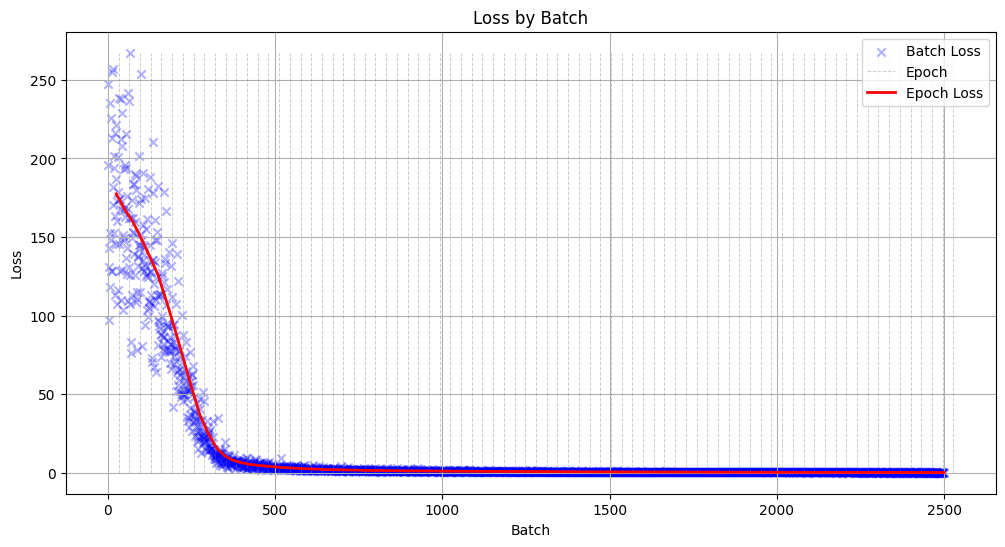

In [39]:
class Optimizer:
    def __init__(self, optimizer_type, lr, weight_shape, bias_shape, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.optimizer_type = optimizer_type
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.t = 0

        self.m_w, self.v_w = np.zeros(weight_shape), np.zeros(weight_shape)
        self.m_b, self.v_b = np.zeros(bias_shape), np.zeros(bias_shape)

    def update(self, weights, biases, d_weights, d_bias):
        self.t += 1
        if self.optimizer_type == 'sgd':
            weights -= self.lr * d_weights
            biases -= self.lr * d_bias
        elif self.optimizer_type == 'momentum':
            self.m_w = self.beta1 * self.m_w + (1 - self.beta1) * d_weights
            self.m_b = self.beta1 * self.m_b + (1 - self.beta1) * d_bias
            weights -= self.lr * self.m_w
            biases -= self.lr * self.m_b
        elif self.optimizer_type == 'adam':
            self.m_w = self.beta1 * self.m_w + (1 - self.beta1) * d_weights
            self.v_w = self.beta2 * self.v_w + (1 - self.beta2) * (d_weights ** 2)
            self.m_b = self.beta1 * self.m_b + (1 - self.beta1) * d_bias
            self.v_b = self.beta2 * self.v_b + (1 - self.beta2) * (d_bias ** 2)

            m_w_hat = self.m_w / (1 - self.beta1 ** self.t)
            v_w_hat = self.v_w / (1 - self.beta2 ** self.t)
            m_b_hat = self.m_b / (1 - self.beta1 ** self.t)
            v_b_hat = self.v_b / (1 - self.beta2 ** self.t)

            weights -= self.lr * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
            biases -= self.lr * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)

        return weights, biases

class NeuralNet(object):
    
    def __init__ (self, input_dim, output_dim, neurons = [], loss_function='mse', activation_function='relu', optimizer_type='adam', learning_rate=1e-3):
        n_ins  = [input_dim] + neurons 
        n_outs = neurons + [output_dim]

        self.weights = [weight_initialization(n_in, n_out) for n_in,n_out in zip(n_ins, n_outs)]
        self.biases = [bias_initialization(n_out) for n_out in n_outs]
        self.activation_functions = [activation_function] * len(neurons) + ["none"]

        loss_functions = {
            'mse': (MSE_loss, d_MSE_loss),
            'log_loss': (log_loss, d_log_loss)
        }
        self.loss, self.d_loss = loss_functions[loss_function]
        self.optimizers = [Optimizer(optimizer_type, learning_rate, w.shape, b.shape) for w, b in zip(self.weights, self.biases)]

    
    def forward(self, x):
        # TODO: Add support for a bias for each neuron in the code below.
        for layer_weights, layer_biases, layer_activation_function in zip(self.weights, self.biases, self.activation_functions):
            x = propagate_forward(layer_weights, x, layer_biases, layer_activation_function)
        return x
    
    def adjust_weights(self, x, y):
                
        activation = x 
        activation_history = [] 
        
        for layer_weights, layer_biases, layer_activation_function in zip(self.weights, self.biases, self.activation_functions):
            activation_history.append(activation)
            activation = propagate_forward(layer_weights, activation, layer_biases, layer_activation_function)
           
        loss = self.loss(activation,y)
        
        dl_dz = self.d_loss(activation,y) 

        for current_layer, (layer_weights, layer_biases, layer_activation_function, previous_activations) in reversed(list(enumerate(zip(self.weights, self.biases, self.activation_functions, activation_history)))):
            d_weights, d_bias, dl_dz = propagate_backward(layer_weights, previous_activations,  dl_dz, layer_biases, layer_activation_function)
            self.weights[current_layer], self.biases[current_layer] = self.optimizers[current_layer].update(
                layer_weights, layer_biases, d_weights, d_bias
            )
        return loss
    
    def train_net(self, X, y, batch_size=32, epochs=100, use_validation_data=False, validation_split=0.2, patience=5, decay_factor=0.5, decay_patience=5, min_lr=1e-6):
        losses = []
        best_val_loss = float('inf')
        avg_epoch_loss = []
        patience_counter = 0
        decay_counter = 0

        if use_validation_data:
            val_size = int(validation_split * X.shape[0])
            X_train, X_val = X[:-val_size], X[-val_size:]
            y_train, y_val = y[:-val_size], y[-val_size:]
        else:
            X_train, y_train = X, y
        
        for epoch in range(epochs):
            shuffled_indices = np.arange(X_train.shape[0])
            np.random.shuffle(shuffled_indices)
            X_train = X_train[shuffled_indices, :]
            y_train = y_train[shuffled_indices]
            batch_count = X_train.shape[0] // batch_size
            total_epoch_loss = 0
            
            for batch in range(batch_count):
                mini_batch = X_train[batch*batch_size:(batch+1)*batch_size, :]
                mini_y = y_train[batch*batch_size:(batch+1)*batch_size]
                loss = self.adjust_weights(mini_batch, mini_y)
                losses.append(loss)
                total_epoch_loss += loss
            
            mean_epoch_loss = total_epoch_loss / batch_count
            avg_epoch_loss.append(mean_epoch_loss)
            
            # if epoch % 5 == 0:
            # print(f'{epoch}. LOSS: {mean_epoch_loss}')
            
            if use_validation_data:
                val_predictions = self.forward(X_val)
                val_loss = self.loss(val_predictions, y_val)
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    decay_counter = 0
                else:
                    patience_counter += 1
                    decay_counter += 1

                    if decay_counter >= decay_patience: 
                        new_learning_rate = max(learning_rate * decay_factor, min_lr)  
                        # print(f"Reducing learning rate from {learning_rate} to {new_learning_rate}")
                        self.learning_rate = new_learning_rate
                        decay_counter = 0 

                    if patience_counter >= patience:
                        # print(f"Early stopping at epoch {epoch+1} with validation loss {val_loss}")
                        return losses, avg_epoch_loss
        
        return losses, avg_epoch_loss

batch_size = 32
batch_count = 32
rows = batch_size * batch_count
features = 4
epochs = 100
v_s = 0.2
new_batches_by_epoch = int((rows * (1-v_s))/batch_size)

# y = k*X, 
# NN models 'k' 
k = np.random.randint(0,10,(features,1))
X = np.random.normal(0,1,(rows,features))
y = np.dot(X,k) + 0.1 + np.random.normal(0,0.01,(rows,1))
nn = NeuralNet(features, 1, [18, 12], activation_function='leaky_relu', optimizer_type='adam', learning_rate=1e-3)
losses_by_batch, losses_by_epoch = nn.train_net(X, y, batch_size=32, epochs=epochs, use_validation_data=True, validation_split=v_s)

plt.figure(figsize=(12,6))
plt.scatter(range(len(losses_by_batch)), losses_by_batch, marker='x', alpha=0.3, color='blue', zorder=1, label='Batch Loss')
plt.vlines(x=np.arange(0, len(losses_by_batch) + batch_size, batch_size)[1:], color='gray', linestyle='--', label=f'Epoch', alpha=0.4, ymin=0, ymax=np.max(losses_by_batch), lw=0.7)
plt.plot(np.arange(0, len(losses_by_epoch)*new_batches_by_epoch + new_batches_by_epoch, new_batches_by_epoch)[1:], losses_by_epoch, alpha=1, color='red', lw=2, zorder=2, label='Epoch Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Loss by Batch')
plt.grid()
plt.legend()
plt.show()

## Train Neural Networks

### 7) Simple test

In this a very simple test for you to use and toy around with before using the datasets.

Make sure to test both the **adjust_weights** function and the **train_net** function. What is the difference between the two?

Also, be sure to **plot the loss for each epoch** to see how the network training is progressing!

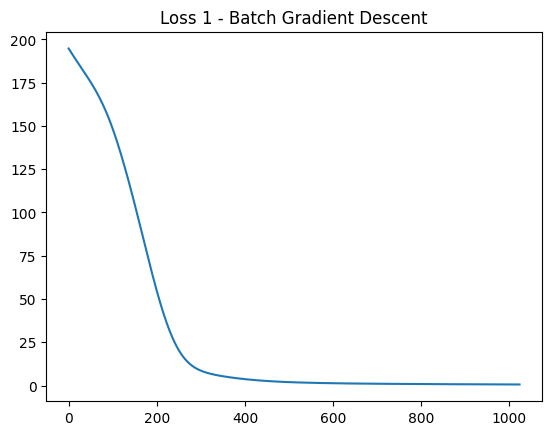

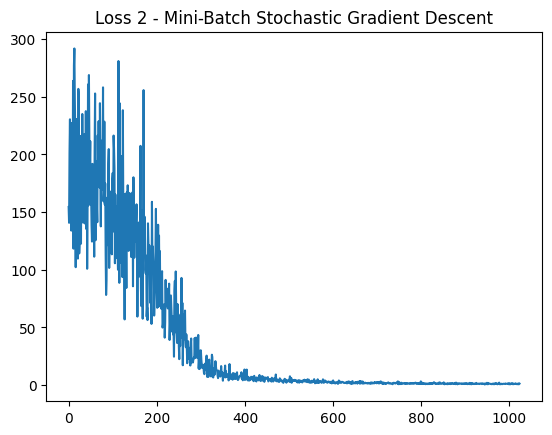

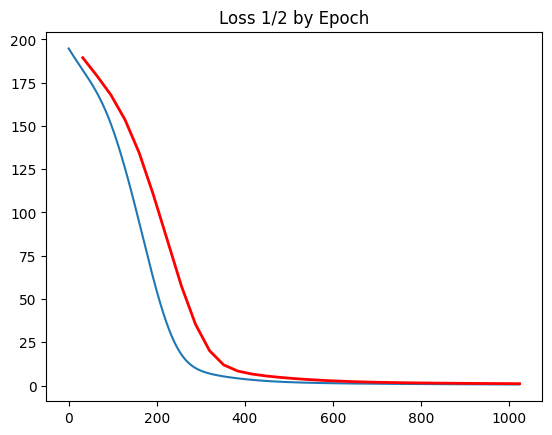

In [14]:
rows = 1024
features = 4
k = np.random.randint(0,10,(features,1))
X = np.random.normal(0,1,(rows,features))
y = np.dot(X,k) + 0.1 + np.random.normal(0,0.01,(rows,1))

np.random.seed(42)
nn = NeuralNet(features, 1, [18, 12])
epochs = 1024
loss_1 = [nn.adjust_weights(X, y) for _ in range(epochs)] 

np.random.seed(42)
nn = NeuralNet(features, 1, [18, 12])
epochs = 32
loss_2 = nn.train_net(X, y, epochs=epochs)[0]

plt.plot(loss_1)
plt.title("Loss 1 - Batch Gradient Descent")
plt.show()

plt.plot(loss_2)
plt.title("Loss 2 - Mini-Batch Stochastic Gradient Descent")
plt.show()

plt.title("Loss 1/2 by Epoch")
plt.plot(loss_1)
losses_by_epoch_2 = np.mean(np.array_split(loss_2, indices_or_sections = len(loss_2) / batch_count), axis=1)
plt.plot(np.arange(0, epochs * batch_size + batch_size, batch_size)[1:], losses_by_epoch_2, alpha=1, color='red', lw=2, zorder=2, label='Epoch Loss')
plt.show()

# FALL Batches:
    - 1000 epoker
      - för varje batch, har 1024 samples
        - gradient -> viktuppdatering
- 1000*1*1024 = 1.024*10^6 (#epoker * #viktuppdateringar * batch_size)

# FALL Mini-Batches:
    - 32 epoker
      - för varje batch, har 32 samples
        - gradient -> viktuppdatering
- 32*32*32 = 3.2*10^4 (#epoker * #viktuppdateringar * batch_size)

# Ordo Analysis
  - Matrix Mult. is O(n^2)
  - Dot product between two vectors of sizes (n,1)*(1,m) is O(n)
- Biggest time save is in the Matrix Mult.

### Real test and preprocessing

When using real data and neural networks, it is very important to scale the data between smaller values, usually between 0 and 1. This is because neural networks struggle with larger values as input compared to smaller values. 

To test this, we will use our first dataset and test with and without scaling.

Similar as with assignment 2, we will use the scikit-learn library for this preprocessing: https://scikit-learn.org/stable/modules/preprocessing.html

# JBV


Mean Absolute Error: 0.03957293086857562

Mean Squared Error: 0.004503848387417434

R^2: 0.38433752054431414


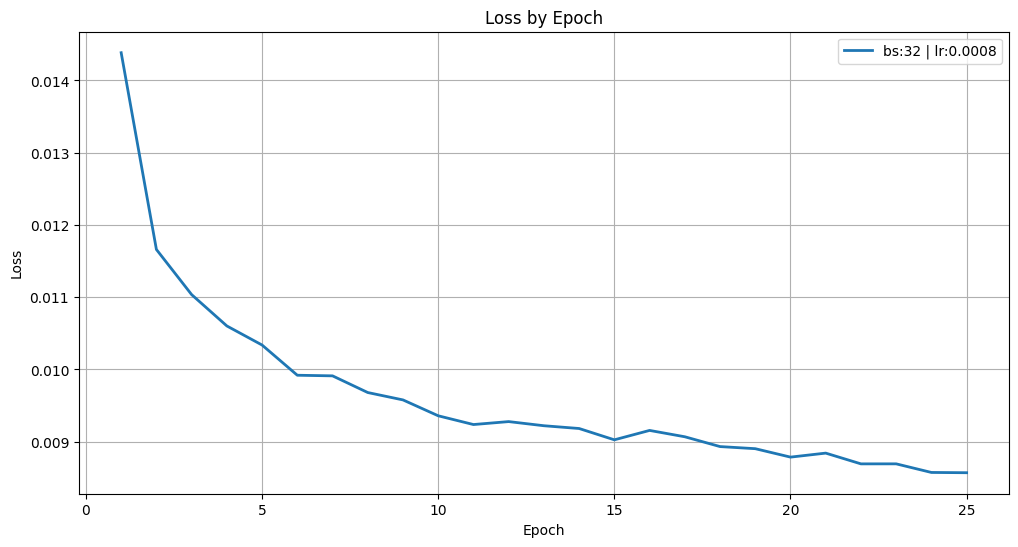

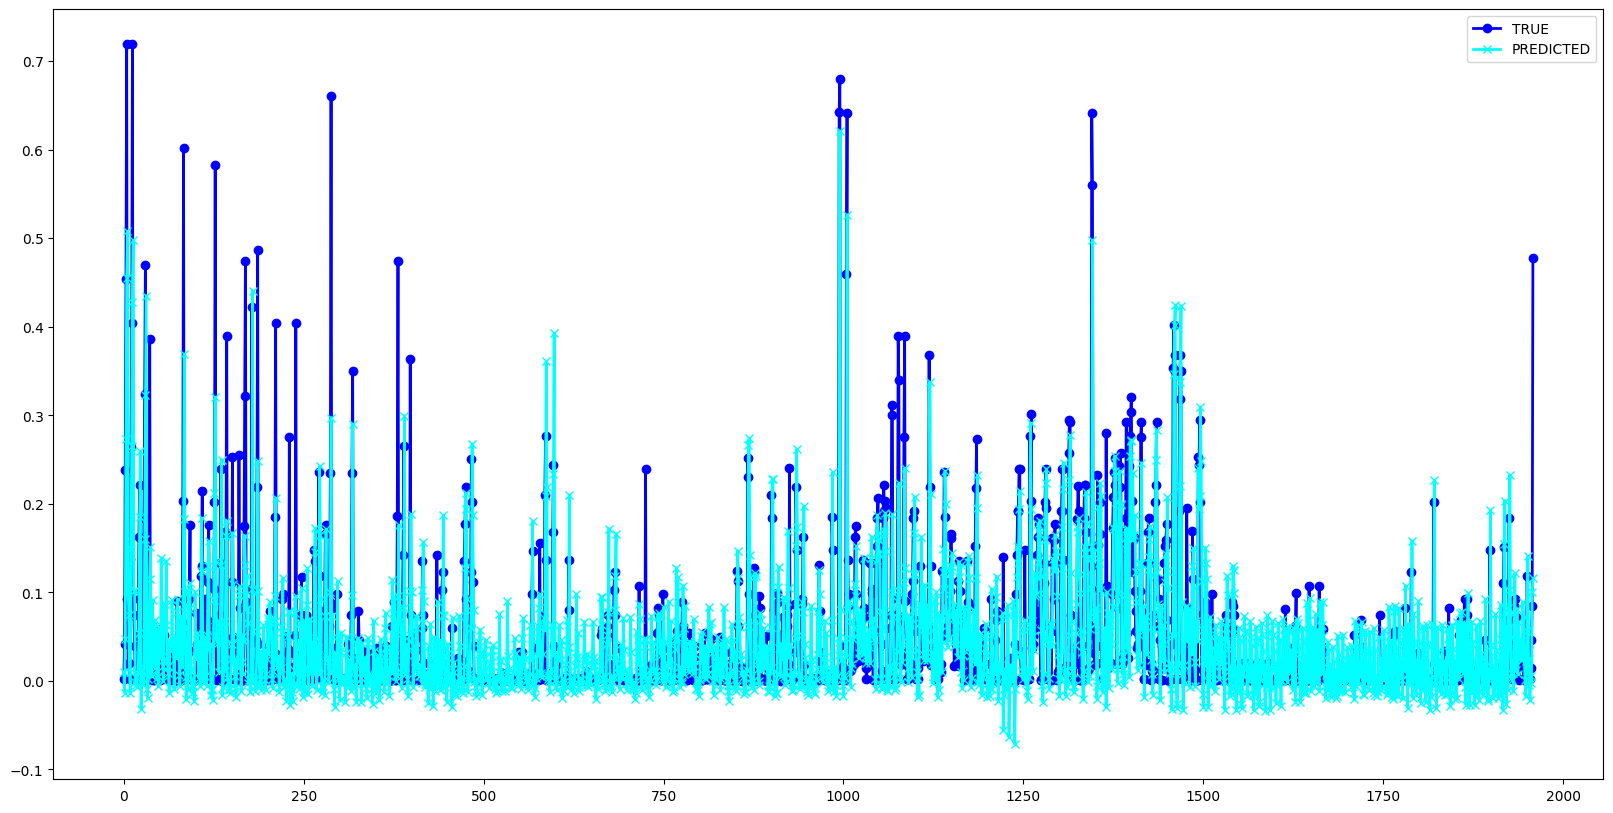

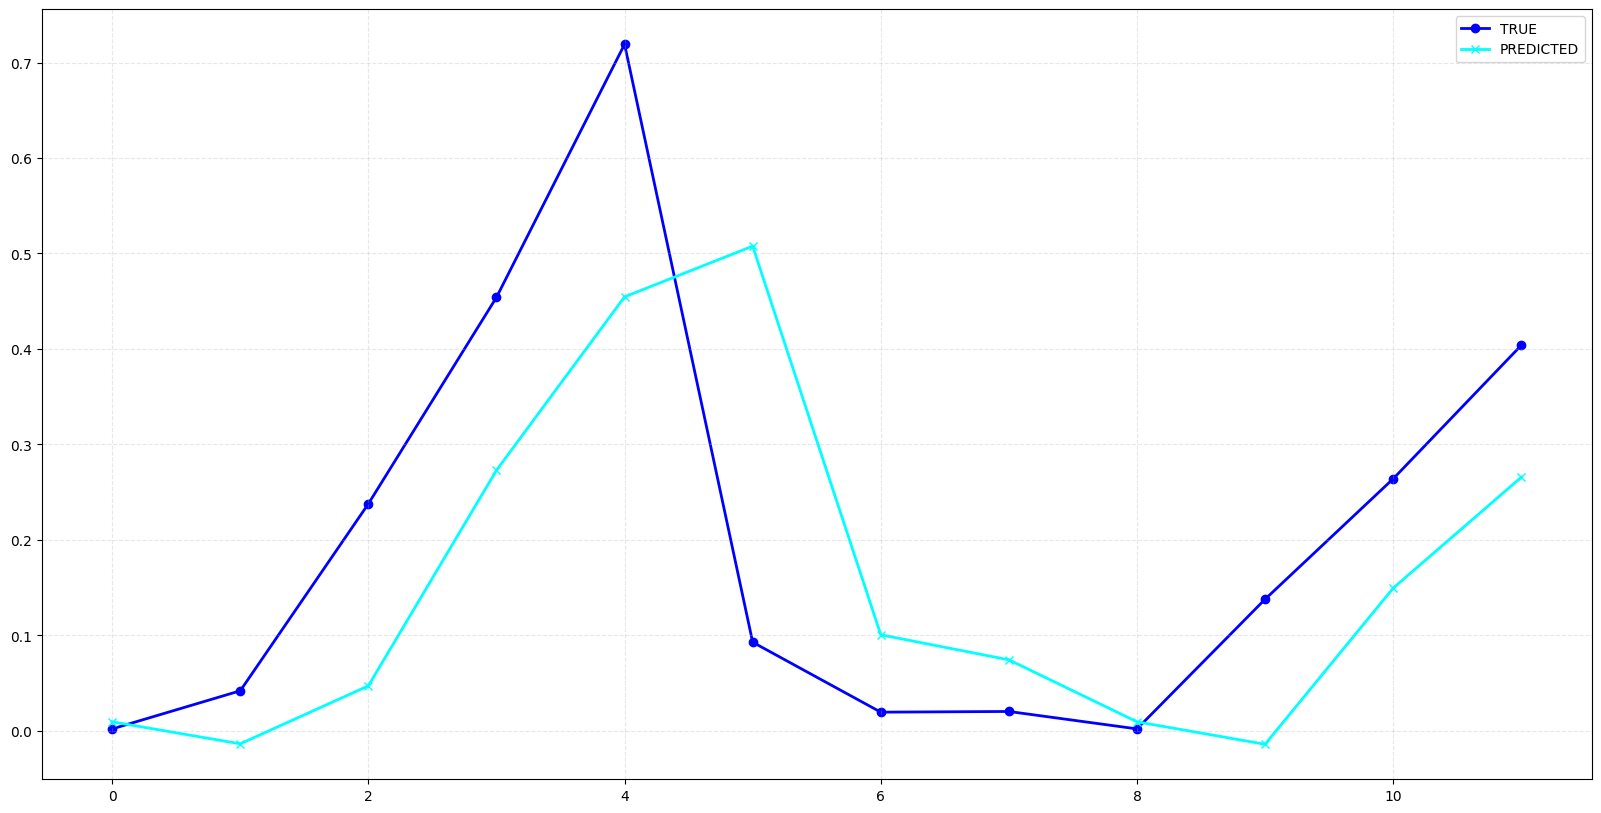

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

rows = 13016

batch_size = 32
epochs = 100
layer_sizes = 3 * [2*features]
patience = 8
learning_rate = 0.0008
X_train = np.array(pd.read_csv('nn_data/reg/X_train_n.csv').drop('Column0', axis=1).head(rows - (rows % batch_size)))
y_train = np.array(pd.read_csv('nn_data/reg/y_train_n.csv').drop('Column0', axis=1).head(rows - (rows % batch_size)))
X_test = np.array(pd.read_csv('nn_data/reg/X_test_n.csv').drop('Column0', axis=1))
y_test = np.array(pd.read_csv('nn_data/reg/y_test_n.csv').drop('Column0', axis=1))

features = pd.read_csv('nn_data/reg/X_train_n.csv').drop('Column0', axis=1).shape[1]

nn = NeuralNet(input_dim=features, output_dim=1, neurons=layer_sizes, loss_function='mse',  activation_function='gelu', optimizer_type='adam', learning_rate=learning_rate)

activations = nn.forward(X_test)

# Train the neural network for one epoch and get the losses
losses_by_epoch = nn.train_net(X_train, y_train, epochs=epochs, batch_size=batch_size, use_validation_data=True, patience=patience)[1]
 
activations = nn.forward(X_test)
print('\nMean Absolute Error:', mean_absolute_error(y_true=y_test, y_pred=activations))
print('\nMean Squared Error:', mean_squared_error(y_true=y_test, y_pred=activations))
print('\nR^2:', r2_score(y_true=y_test, y_pred=activations))

plt.figure(figsize=(12,6))
plt.plot(np.arange(0, len(losses_by_epoch)+1)[1:], losses_by_epoch, alpha=1, color='tab:blue', lw=2, zorder=2, label=f'bs:{batch_size} | lr:{learning_rate}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss by Epoch')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(20,10))
plt.plot(range(len(y_test)),y_test, color='blue', zorder=1, lw=2, marker='o', label='TRUE')
plt.plot(range(len(activations)),activations, color='cyan', lw=2, marker='x', label='PREDICTED')
plt.legend()
plt.show()

plt.figure(figsize=(20,10))
plt.plot(range(len(y_test[:12])),y_test[:12], color='blue', zorder=1, lw=2, marker='o', label='TRUE')
plt.plot(range(len(activations[:12])),activations[:12], color='cyan', lw=2, marker='x', label='PREDICTED')
plt.grid(alpha=.3, ls='--')
plt.legend()
plt.show()


Mean Absolute Error: 0.11839887915231574

Mean Squared Error: 0.018866521197523172

R^2: -0.4458543429068984


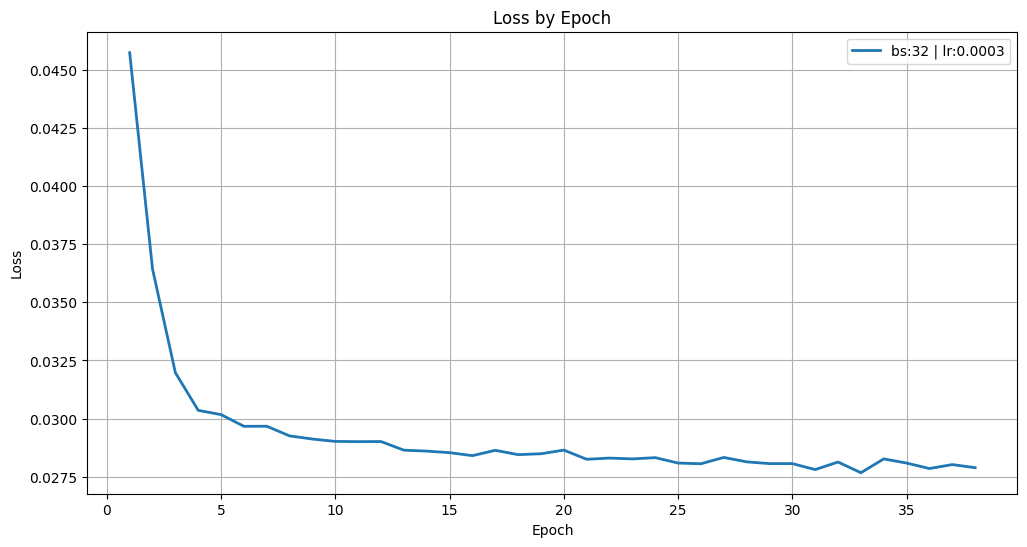

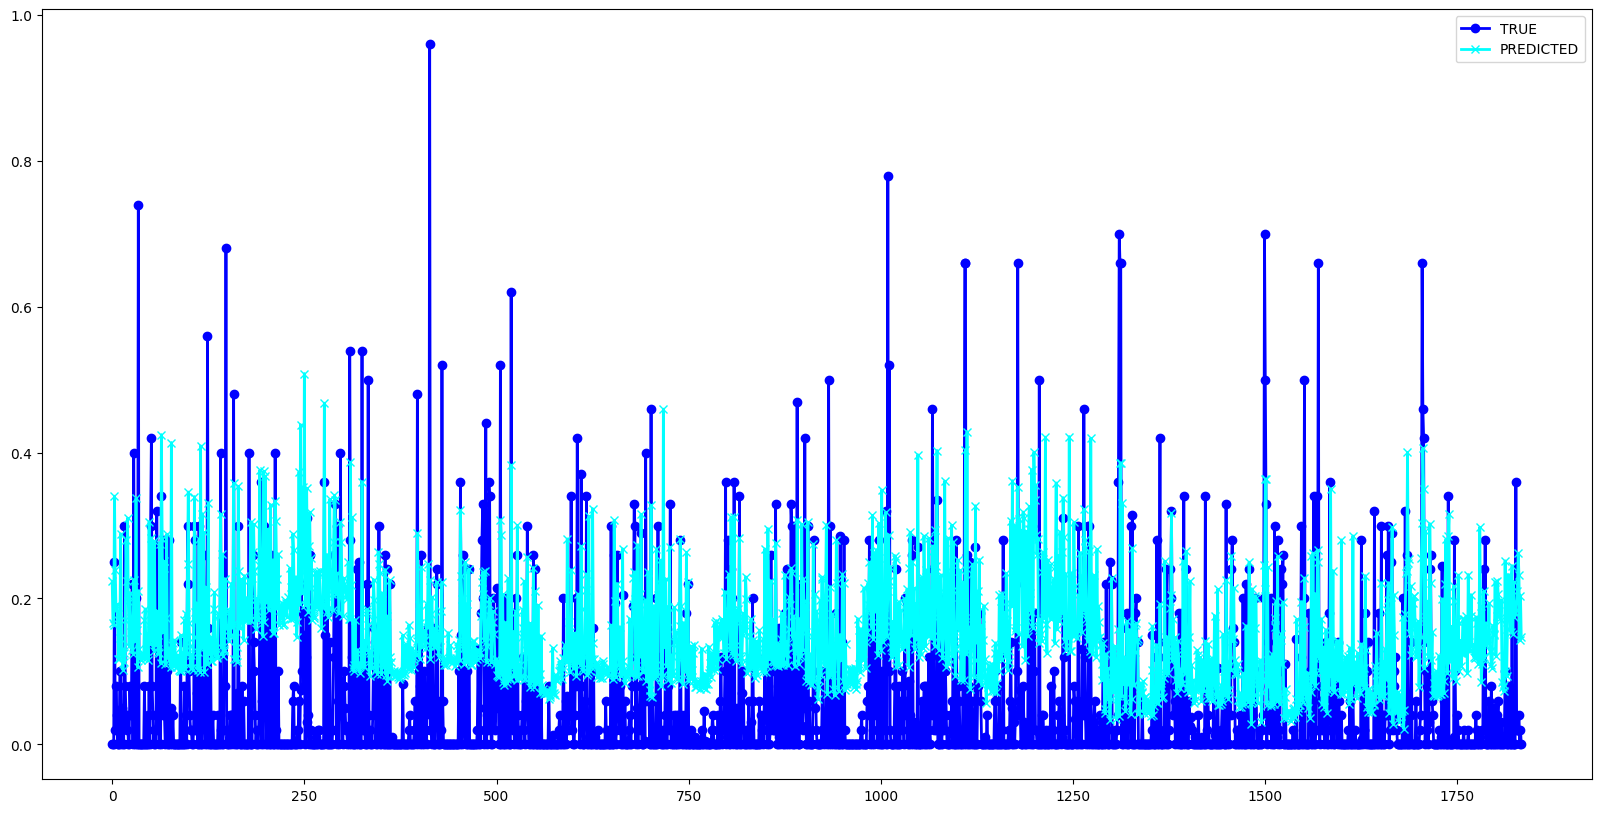

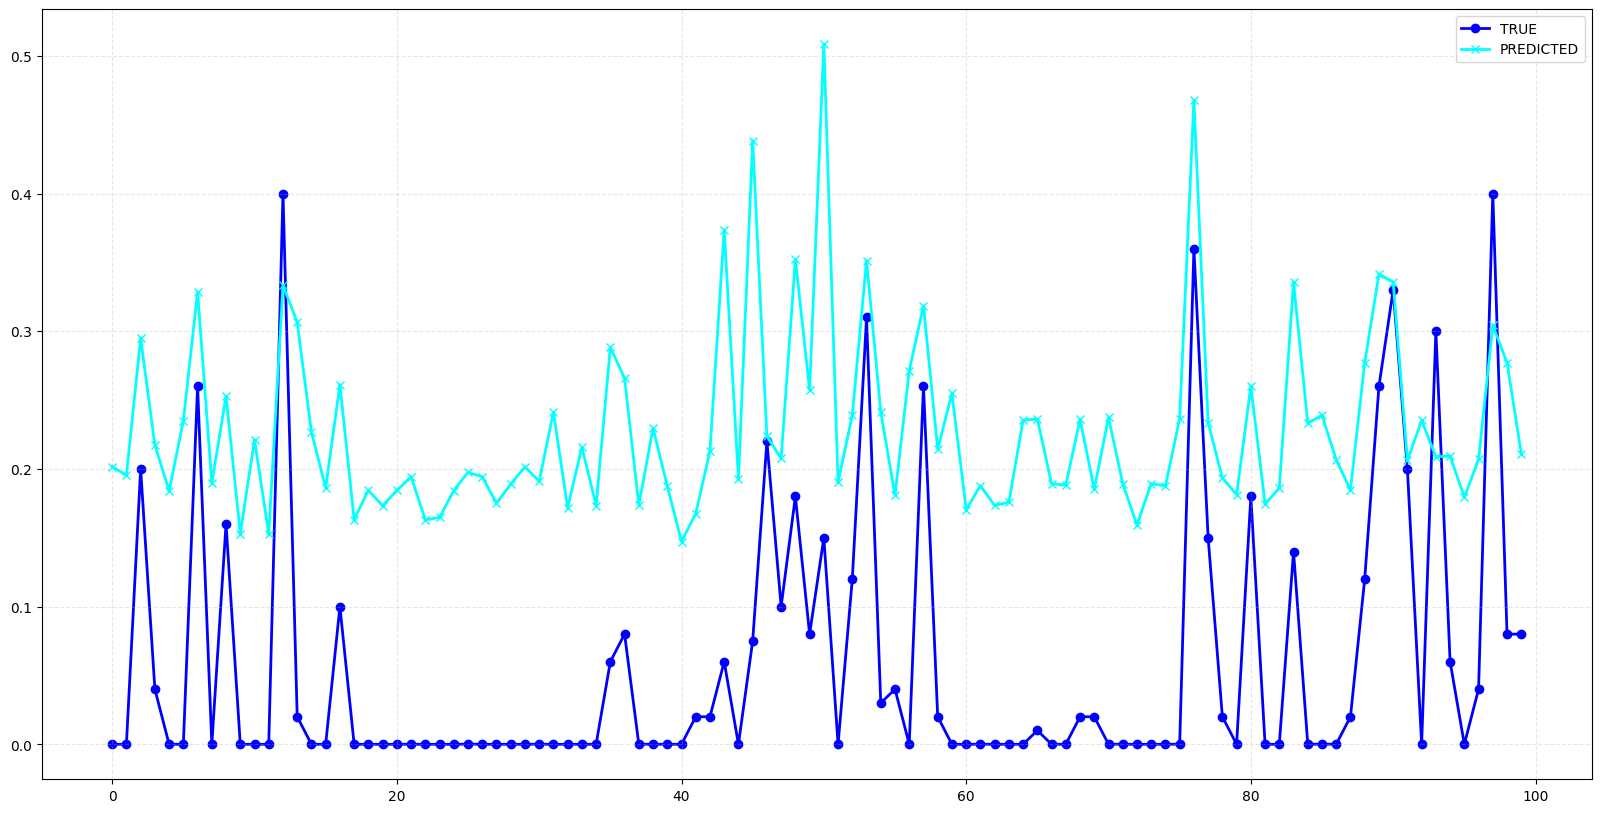

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

rows = 4252

batch_size = 32
epochs = 100
layer_sizes = 3 * [2*features]
patience = 8
learning_rate = 0.0003

y_train = np.array(pd.read_csv('./nn_data/reg/new/y_train.csv').head(rows - (rows % batch_size)))
X_train = np.array(pd.read_csv('./nn_data/reg/new/X_train.csv').head(rows - (rows % batch_size)))
X_test = np.array(pd.read_csv('./nn_data/reg/new/X_test.csv'))
y_test = np.array(pd.read_csv('./nn_data/reg/new/y_test.csv'))

features = pd.read_csv('./nn_data/reg/new/X_train.csv').shape[1]

nn = NeuralNet(input_dim=features, output_dim=1, neurons=layer_sizes, loss_function='mse',  activation_function='gelu', optimizer_type='adam', learning_rate=learning_rate)

activations = nn.forward(X_test)

# Train the neural network for one epoch and get the losses
losses_by_epoch = nn.train_net(X_train, y_train, epochs=epochs, batch_size=batch_size, use_validation_data=True, patience=patience)[1]
 
activations = nn.forward(X_test)
print('\nMean Absolute Error:', mean_absolute_error(y_true=y_test, y_pred=activations))
print('\nMean Squared Error:', mean_squared_error(y_true=y_test, y_pred=activations))
print('\nR^2:', r2_score(y_true=y_test, y_pred=activations))

plt.figure(figsize=(12,6))
plt.plot(np.arange(0, len(losses_by_epoch)+1)[1:], losses_by_epoch, alpha=1, color='tab:blue', lw=2, zorder=2, label=f'bs:{batch_size} | lr:{learning_rate}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss by Epoch')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(20,10))
plt.plot(range(len(y_test)),y_test, color='blue', zorder=1, lw=2, marker='o', label='TRUE')
plt.plot(range(len(activations)),activations, color='cyan', lw=2, marker='x', label='PREDICTED')
plt.legend()
plt.show()

plt.figure(figsize=(20,10))
from_p = 200
to_p = 300
plt.plot(range(len(y_test[from_p:to_p])),y_test[from_p:to_p], color='blue', zorder=1, lw=2, marker='o', label='TRUE')
plt.plot(range(len(activations[from_p:to_p])),activations[from_p:to_p], color='cyan', lw=2, marker='x', label='PREDICTED')
plt.grid(alpha=.3, ls='--')
plt.legend()
plt.show()

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from itertools import combinations

num_features = X_train.shape[1]
feature_names = pd.read_csv('nn_data/reg/X_train_n.csv').drop('Column0', axis=1).columns
mse_results = pd.DataFrame(index=range(num_features), columns=range(num_features))

# Evaluate all pairwise combinations of features
for i, j in combinations(range(num_features), 2):
    # Select the pair of features
    X_train_subset = X_train[:, [i, j]]
    X_test_subset = X_test[:, [i, j]]
    
    # Train a Decision Tree Regressor
    model = DecisionTreeRegressor(random_state=42)
    model.fit(X_train_subset, y_train)
    
    # Make predictions and evaluate performance using Mean Squared Error
    y_pred = model.predict(X_test_subset)
    mse = mean_squared_error(y_test, y_pred)
    
    # Store the MSE in the results DataFrame
    mse_results.loc[i, j] = mse
    mse_results.loc[j, i] = mse  

    print(f'Feature Combination: ({i+1}, {j+1})')

# Fill diagonal with NaN or a specific value (e.g., 0)
np.fill_diagonal(mse_results.values, np.nan)

Feature Combination: (1, 2)
Feature Combination: (1, 3)
Feature Combination: (1, 4)
Feature Combination: (1, 5)
Feature Combination: (1, 6)
Feature Combination: (1, 7)
Feature Combination: (1, 8)
Feature Combination: (1, 9)
Feature Combination: (1, 10)
Feature Combination: (1, 11)
Feature Combination: (1, 12)
Feature Combination: (1, 13)
Feature Combination: (1, 14)
Feature Combination: (1, 15)
Feature Combination: (1, 16)
Feature Combination: (1, 17)
Feature Combination: (1, 18)
Feature Combination: (1, 19)
Feature Combination: (1, 20)
Feature Combination: (1, 21)
Feature Combination: (1, 22)
Feature Combination: (1, 23)
Feature Combination: (1, 24)
Feature Combination: (1, 25)
Feature Combination: (1, 26)
Feature Combination: (1, 27)
Feature Combination: (2, 3)
Feature Combination: (2, 4)
Feature Combination: (2, 5)
Feature Combination: (2, 6)
Feature Combination: (2, 7)
Feature Combination: (2, 8)
Feature Combination: (2, 9)
Feature Combination: (2, 10)
Feature Combination: (2, 11)


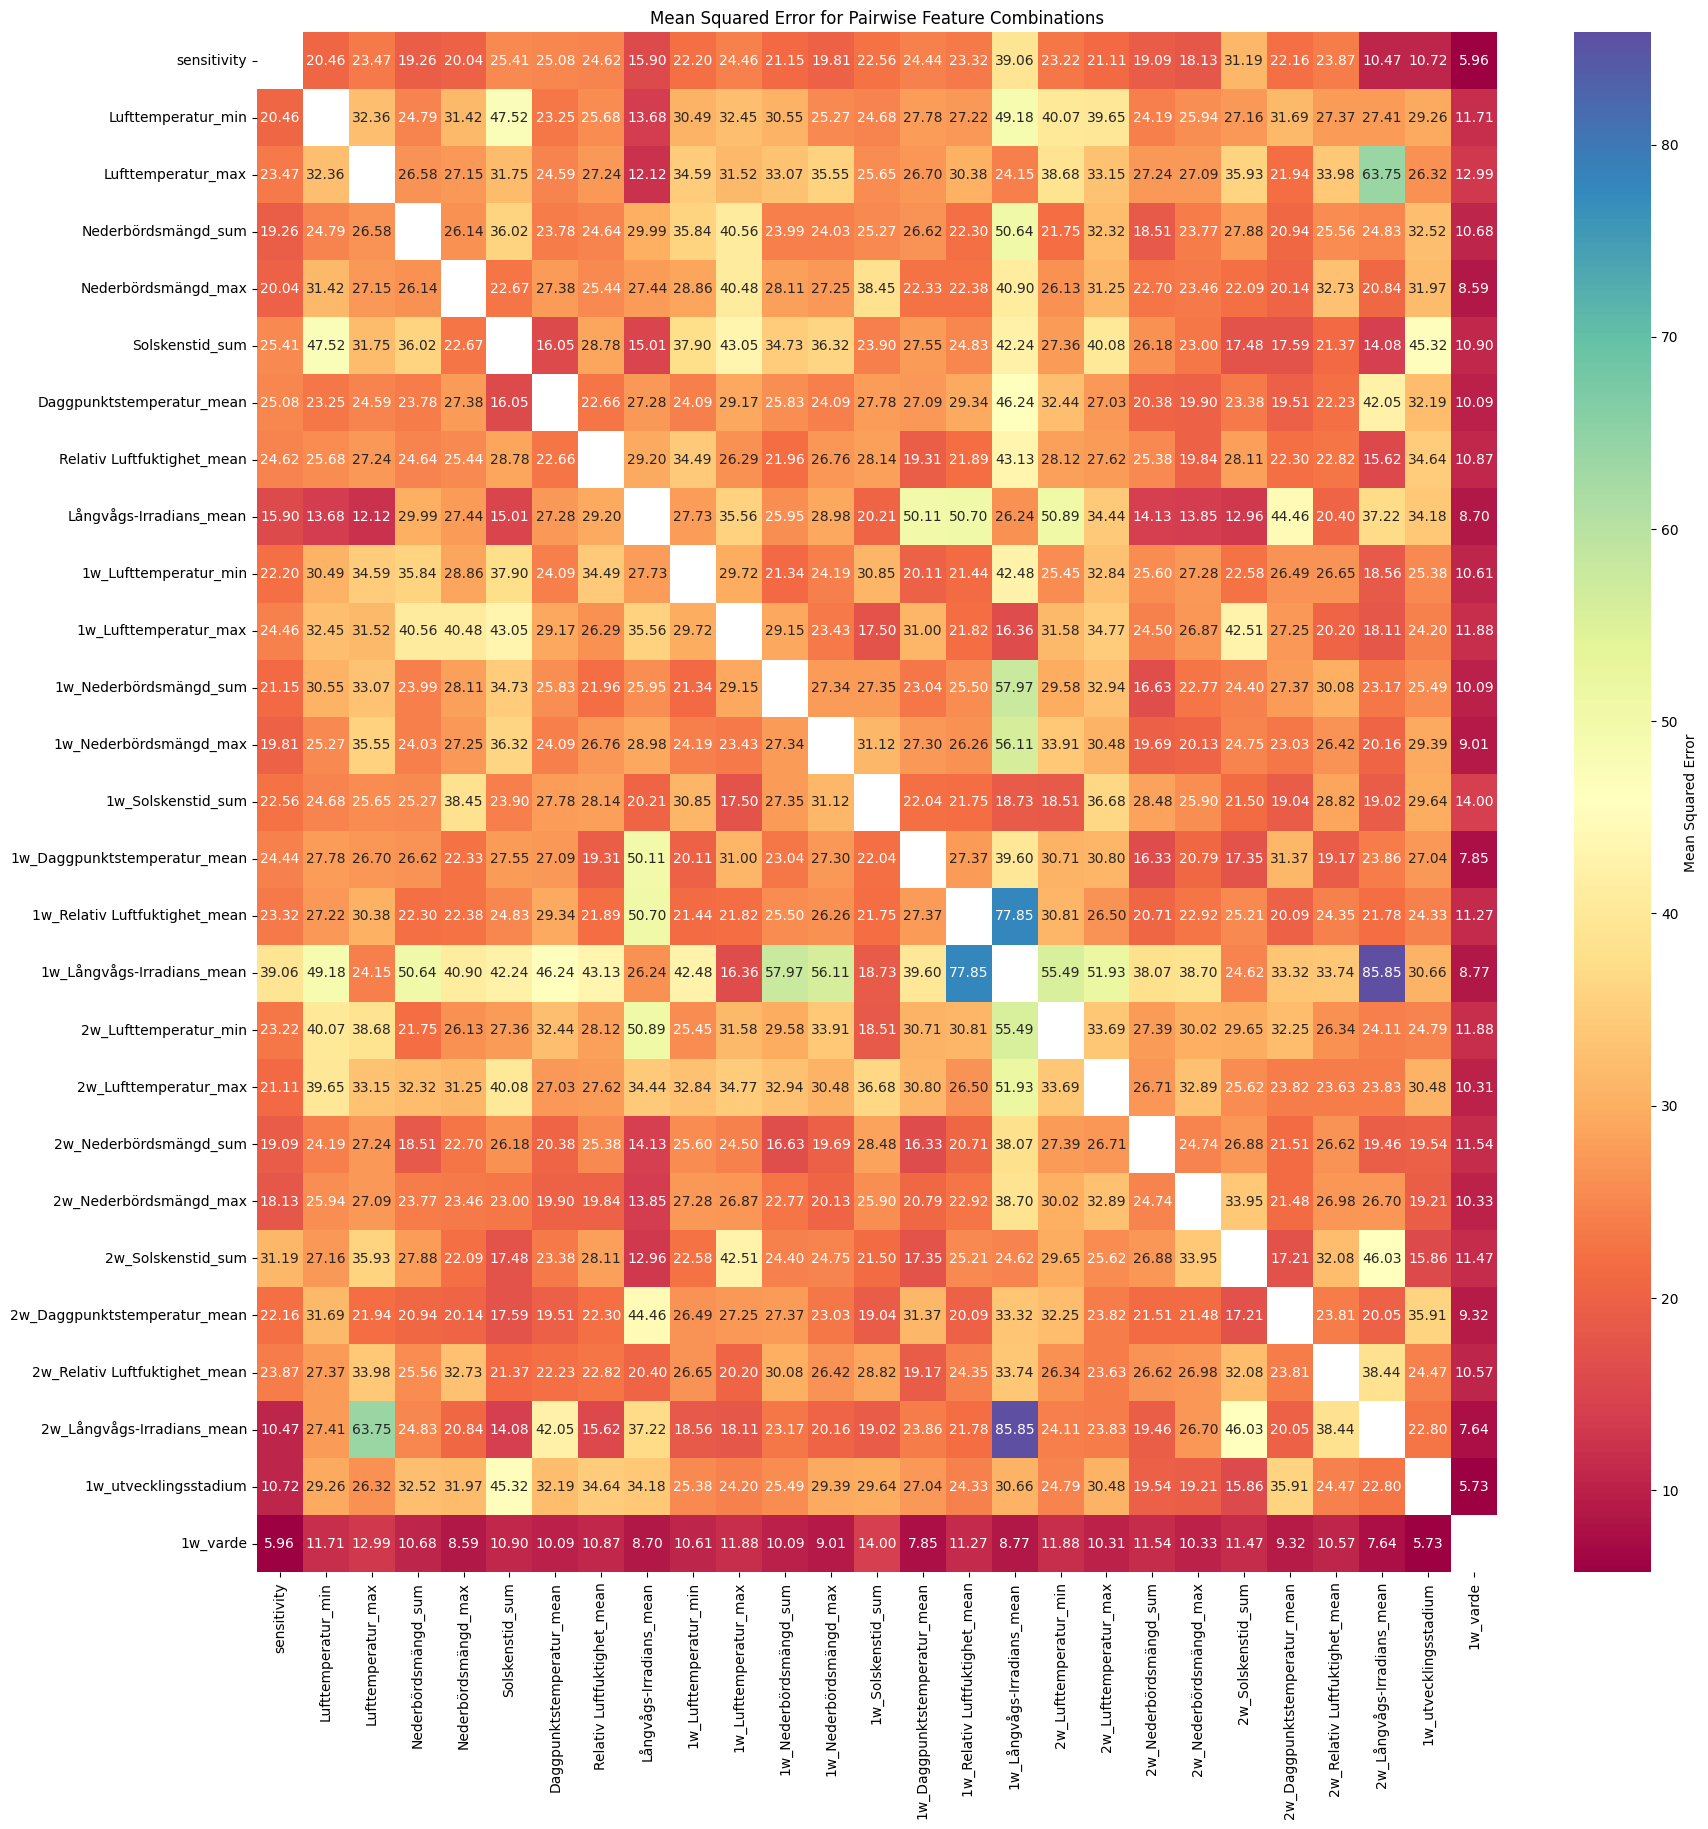

In [ ]:
# Visualize the results in a heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(1000*mse_results.astype(float), annot=True, fmt=".2f", cmap='Spectral', 
            xticklabels=[f'{feature_names[i]}' for i in range(len(feature_names))],
            yticklabels=[f'{feature_names[i]}' for i in range(len(feature_names))],
            cbar_kws={'label': 'Mean Squared Error'})
plt.title('Mean Squared Error for Pairwise Feature Combinations')
plt.show()


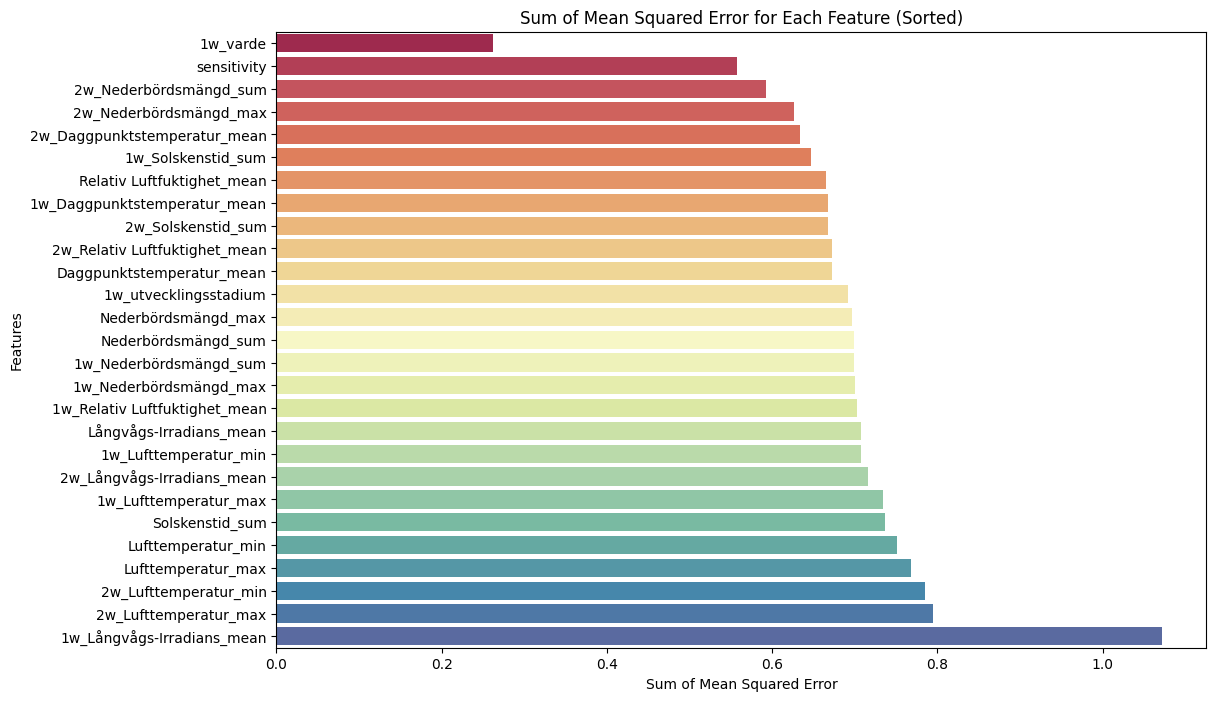

In [21]:
mse_sums = mse_results.sum(axis=1)
mse_df = pd.DataFrame({'Feature': feature_names, 'MSE Sum': mse_sums})
mse_df_sorted = mse_df.sort_values(by='MSE Sum')

plt.figure(figsize=(12, 8))
sns.barplot(x='MSE Sum', y='Feature', data=mse_df_sorted, palette='Spectral')
plt.xlabel('Sum of Mean Squared Error')
plt.ylabel('Features')
plt.title('Sum of Mean Squared Error for Each Feature (Sorted)')
plt.show()


In [22]:
mse_df_sorted[:6]

,Feature,MSE Sum
26,1w_varde,0.262754
0,sensitivity,0.557168
19,2w_Nederbördsmängd_sum,0.592224
20,2w_Nederbördsmängd_max,0.626623
22,2w_Daggpunktstemperatur_mean,0.634062
13,1w_Solskenstid_sum,0.647566


In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load your data
rows = 13016
batch_size = 32
epochs = 100
X_train = np.array(pd.read_csv('nn_data/reg/X_train_n.csv').drop('Column0', axis=1).head(rows - (rows % batch_size)))
y_train = np.array(pd.read_csv('nn_data/reg/y_train_n.csv').drop('Column0', axis=1).head(rows - (rows % batch_size)))
X_test = np.array(pd.read_csv('nn_data/reg/X_test_n.csv').drop('Column0', axis=1))
y_test = np.array(pd.read_csv('nn_data/reg/y_test_n.csv').drop('Column0', axis=1))

feature_names = pd.read_csv('nn_data/reg/X_train_n.csv').drop('Column0', axis=1).columns.tolist()

# Neural network parameters
features = X_train.shape[1]
layer_sizes = 3 * [2*features]
learning_rate = 0.0008
patience = 8
RUNS = 10

# Initialize variables
max_features = mse_df_sorted.shape[0]  # Use all features available in mse_df_sorted
average_r2_scores = []
previous_r2 = -np.inf  # Start with a very low R² score

log_file_path = 'nn_training_log.txt'
with open(log_file_path, 'w') as log_file:
    # Log the settings of the neural network
    log_file.write("Neural Network Training Settings:\n")
    log_file.write(f"Input Features: {features}\n")
    log_file.write(f"Layer Sizes: {layer_sizes}\n")
    log_file.write(f"Learning Rate: {learning_rate}\n")
    log_file.write(f"Batch Size: {batch_size}\n")
    log_file.write(f"Epochs: {epochs}\n")
    log_file.write(f"Patience: {patience}\n")
    log_file.write(f"Runs/Combination: {RUNS}\n")
    log_file.write("\nAVERAGE R2 SCORES FOR EACH FEATURE COMBINATION:\n")

# Iterate through the top features
chunk_size = 4
for num_features in range(1, max_features + 1, chunk_size):
    # Select the top features based on mse_df_sorted
    selected_features_indices = mse_df_sorted.index[:num_features].tolist()
    selected_feature_names = [feature_names[idx] for idx in selected_features_indices]

    # Prepare the feature subsets
    X_train_subset = X_train[:, selected_features_indices]
    X_test_subset = X_test[:, selected_features_indices]
    
    r2_scores = []
    
    with open(log_file_path, 'a') as log_file:
        log_file.write(f'\n')
        log_file.write(f'-- FEATURES: {selected_feature_names} --\n')

    # Run the model 5 times and calculate the average R² score
    for run in range(RUNS):
        nn = NeuralNet(input_dim=num_features, output_dim=1, neurons=layer_sizes, 
                       loss_function='mse', activation_function='gelu', 
                       optimizer_type='adam', learning_rate=learning_rate)

        nn.train_net(X_train_subset, y_train, epochs=epochs, batch_size=batch_size, 
                     use_validation_data=True, patience=patience)
        
        activations = nn.forward(X_test_subset)
        
        r2 = r2_score(y_true=y_test, y_pred=activations)
        r2_scores.append(r2)
        with open(log_file_path, 'a') as log_file:
            log_file.write(f'Run {run+1}. Top {num_features} features. R2 {round(r2, 3)}.\n')
    
    average_r2 = np.mean(r2_scores)
    average_r2_scores.append(average_r2)
    
    with open(log_file_path, 'a') as log_file:
        log_file.write(f'Average R2 for top {num_features} features ({RUNS} runs): {round(average_r2, 3)}\n')
    
    if average_r2 <= previous_r2:
        with open(log_file_path, 'a') as log_file:
            log_file.write(f'\nStopping feature addition at {num_features - 1} features.')
        break
    
    previous_r2 = average_r2

with open(log_file_path, 'a') as log_file:
    log_file.write("\nAverage R2 scores for each feature count:")
    for i, score in enumerate(average_r2_scores):
        log_file.write(f'\nTop {i*chunk_size + 1} features: {round(score, 3)}')